<a href="https://colab.research.google.com/github/Rush358/Fantasy-Premier-League/blob/main/FPL_Optimiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import and install necessary libraries
# ------------------------------------------------------------------------------

%reset -f # Clear all user created variables

# Import modules
import pandas as pd
import urllib
from urllib.error import HTTPError # Module to handle HTTP errors
import matplotlib.pyplot as plt

# Install PuLP
!pip install -U git+https://github.com/coin-or/pulp
from pulp import *

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clear, please run `%reset?` for details
Don't know how to reset  all, please run `%reset?` for details
Don't know how to reset  user, please run `%reset?` for details
Don't know how to reset  created, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
  Cloning https://github.com/coin-or/pulp to /tmp/pip-req-build-96152ap8
  Running command git clone -q https://github.com/coin-or/pulp /tmp/pip-req-build-96152ap8
  Created wheel for PuLP: filename=PuLP-2.4-cp36-none-any.whl size=40575874 sha256=cecd55dc4769ac583d7848692a37eecd8b3d464fef25c34e6d0186c14d1804c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-im2gokxj/wheels/b5/05/85/c8dc75b231283b2f75423fca896c12db41caa924b7f1615205
Successfully built PuLP
  Found existing installation: PuLP 2.4
    Uninstalling PuLP-2.4:
      Successfully uninstalled PuLP-2.4


In [ ]:
# Import FPL data into notebook
# ------------------------------------------------------------------------------

# Pull in CSVs from Git Hub repo (non-gameweek data)
teams = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/teams.csv")
fixtures = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/fixtures.csv")
players_raw = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/players_raw.csv")
players_id = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/player_idlist.csv")

gw_data = [] # Initialise a list to pull in data for each gameweek

# Loop over every GW in the PL season
for i in range(1, 39):
  
  try: # Try to pull in GW information
    gw = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/gw" + str(i) + ".csv") 

  except urllib.error.HTTPError: # If GW doesn't exist yet, a HTTP error will be thrown - needs to be handled
    break # Break loop as GW (and future GWs) don't exist 

  else: # If current iteration GW exists then
    gw['gameweek'] = i # Add a column for this iteration's gameweek
    gw_data.append(gw) # Add GW dataframe to list of  

players = pd.concat(gw_data) # Concatenate list of gameweeks to a single dataframe

In [ ]:
# Cleanse data by selecting wanted columns
# ------------------------------------------------------------------------------

teams_filt = teams[['id', 'strength', 'short_name']]
fixtures_filt = fixtures[['id', 'team_a','team_h']]
players_raw_filt = players_raw[['id','element_type']]
players_filt = players[['name','gameweek', 'value','fixture','opponent_team','total_points','minutes','transfers_balance','was_home']]
players_id['name'] = players_id['first_name'] + ' ' + players_id['second_name']

In [ ]:
# Merge information onto players GW data
# ------------------------------------------------------------------------------

merged = players_filt.merge(fixtures_filt, how = 'left', left_on = 'fixture', right_on = 'id') # Fixture information
merged.drop(columns = ['id'], inplace = True)
merged = merged.merge(players_id, how = 'left', left_on = 'name', right_on = 'name') # Player ID information
merged = merged.merge(players_raw_filt, how = 'left', left_on = 'id', right_on = 'id') # Positional information
merged.rename(columns = {'id':'player_id'}, inplace = True)

In [ ]:
# Merge team information onto players GW data
# ------------------------------------------------------------------------------

import numpy as np

merged['team'] = np.where(merged['was_home'] == True, merged['team_h'], merged['team_a']) # Add player's team

merged = merged.merge(teams_filt, left_on = 'team', right_on = 'id' ) # Add player's team information
merged.rename(columns = {'strength':'team_diff', 'short_name':'team_short'}, inplace = True) # Rename columns before merging to team_filt again

merged = merged.merge(teams_filt, left_on = 'opponent_team', right_on = 'id')# Add opponent team's information
merged.rename(columns = {'strength':'opp_diff', 'short_name':'opp_short'}, inplace = True) # Rename columns

In [ ]:
# Final cleaning of data before analysis
# ------------------------------------------------------------------------------

cleaned = merged.copy(deep = True) # Create a copy of the original before dropping columns
cleaned.drop(columns = ['id_x', 'id_y', 'first_name', 'second_name'], inplace = True) # Remove unnecessary columns

column_order = ['player_id', 'gameweek', 'name', 'element_type', 'value', 'fixture', 'team', 'team_short', 'team_diff', 'opponent_team', 'opp_short', 'opp_diff', 'was_home', 'team_a', 'team_h', 'total_points', 'minutes', 'transfers_balance']
cleaned = cleaned[column_order] # Set column order

In [ ]:
# Check for null values in dataframe
# ------------------------------------------------------------------------------

cols_null = [] # List of columns with null value

for i in range(0, len(cleaned.columns)): # Loop through each column in dataframe
  
  check = cleaned.iloc[:, i].isnull().any() # Check if there any nulls in column

  if check == True:
    cols_null.append(i)

print('No null values found.') if len(cols_null) == 0 else print('Null values found.')

cleaned.head()

No null values found.


,player_id,gameweek,name,element_type,value,fixture,team,team_short,team_diff,opponent_team,opp_short,opp_diff,was_home,team_a,team_h,total_points,minutes,transfers_balance
0,78,1,Aaron Connolly,4,55,7,3,BHA,3,5,CHE,4,True,5,3,1,45,0
1,60,1,Aaron Mooy,3,50,7,3,BHA,3,5,CHE,4,True,5,3,0,0,0
2,54,1,Adam Lallana,3,65,7,3,BHA,3,5,CHE,4,True,5,3,1,44,0
3,66,1,Adam Webster,2,45,7,3,BHA,3,5,CHE,4,True,5,3,1,90,0
4,80,1,Alexis Mac Allister,3,55,7,3,BHA,3,5,CHE,4,True,5,3,0,0,0


In [ ]:
# Extract last 5 GWs of data where players have exceeded threshold number of minutes
# ------------------------------------------------------------------------------

min_threshold = 60
gw_current = cleaned['gameweek'].max()

cleaned_last_5 = cleaned.loc[(cleaned['minutes'] >= min_threshold) & (cleaned['gameweek'] > gw_current - 5)]

In [ ]:
# Summarise players' performance in the last 5 GWs
# ------------------------------------------------------------------------------

# Create a list for columns needed and aggregation types
column_agg = ['player_id', 'gameweek', 'name', 'element_type', 'value', 'team', 'team_short', 'team_diff', 'opp_diff', 'total_points', 'minutes', 'transfers_balance']
column_agg_type = ['max', 'max', 'max', 'max', 'mean', 'max', 'max', 'mean', 'mean', ['mean', 'std'], 'mean', 'mean'] # Max aggregation on column of strings just returns the string

agg_type = {column_agg[i]:column_agg_type[i] for i in range(len(column_agg))} # Create a dictionary to map column to appropriate aggregation

# Aggregate performance of last 5 GWs. Columns need to be renamed as a column hierarchy is created when doing mean and std on total_points.
last_5_agg = cleaned_last_5[column_agg].groupby(by = 'name', as_index = False).agg(agg_type)
last_5_agg.columns = ['player_id', 'gameweek', 'name', 'element_type', 'value', 'team', 'team_short', 'team_diff', 'opp_diff', 'mean_points', 'std_points', 'minutes', 'transfers_balance'] # Rename

last_5_agg.dropna(axis = 0, subset = ['std_points'], inplace = True) # Remove any players which haven't played enough to calculate a stdev
last_5_agg.reset_index(drop = True, inplace = True) # Reset index to account for dropped values

In [ ]:
# Update player value to reflect value in current GW
# ------------------------------------------------------------------------------

# Generate unique list of players
players_unique = last_5_agg['player_id'].unique()

# Loop through each player and set their value to the value of the most recent gameweek
for player in players_unique:

  # Find current value by finding most recent gameweek and extracting value column into an array that's accessed
  value_current = cleaned_last_5.loc[cleaned_last_5['player_id'] == player].nlargest(1, 'gameweek')['value'].values[0] 

  last_5_agg.loc[last_5_agg['player_id'] == player, 'value'] = value_current # Set value for considered player

last_5_agg.head()


,player_id,gameweek,name,element_type,value,team,team_short,team_diff,opp_diff,mean_points,std_points,minutes,transfers_balance
0,435,17,Aaron Cresswell,2,53.0,19,WHU,3,3.2,4.80,3.962323,90.0,30543.80
1,483,17,Aaron Ramsdale,1,47.0,15,SHU,3,3.0,1.80,0.447214,90.0,-6676.00
2,313,17,Aaron Wan-Bissaka,2,53.0,13,MUN,4,3.0,3.50,2.886751,90.0,-5106.75
3,512,17,Abdoulaye Doucouré,3,53.0,7,EVE,3,3.5,3.25,1.892969,90.0,-1408.00
4,54,14,Adam Lallana,3,62.0,3,BHA,3,2.5,2.50,0.707107,87.5,138.00


In [ ]:
# Set up optimisation problem
# ------------------------------------------------------------------------------

# Create the 'prob' variable to contain the problem data
prob1 = pulp.LpProblem('FPL_Optimisation', LpMaximize)

# Create decision variable for each player in data
decision_variables = [] # Initialise empty list

for row, player in last_5_agg.iterrows():
  dv_name = str('x' + str(row))
  dv = pulp.LpVariable(name = str(dv_name), lowBound = 0, upBound = 1, cat= 'Integer') # Generate binary decision variables
  decision_variables.append(dv) # Add to list

In [ ]:
# Objective function (i.e. maximise points)
# ------------------------------------------------------------------------------

points_total = "" # Generate a string for the objective function

# Loop through each player's 5GW aggregated data, for their component of the objective function
for row, player in last_5_agg.iterrows():
  
  # Multiply the player's decision variable by their mean points to create their component of objective function
  points_comp = player['mean_points'] * decision_variables[row] # decision_variables row index aligns with last_5_agg row index

  points_total += points_comp # Append component to objective function

prob1 += points_total # Add objective function to LP problem

print(points_total)

4.8*x0 + 1.8*x1 + 5.25*x10 + 8.25*x100 + 4.2*x101 + 1.6666666666666667*x102 + 3.0*x103 + 4.8*x104 + 5.4*x105 + x106 + 7.666666666666667*x107 + 2.3333333333333335*x108 + 2.6*x109 + 10.0*x11 + 4.75*x110 + 3.75*x111 + 4.25*x112 + 5.0*x113 + 3.0*x114 + 6.0*x115 + 5.2*x116 + 2.0*x117 + 2.3333333333333335*x118 + 2.0*x119 + 3.8*x12 + 4.333333333333333*x120 + 4.333333333333333*x121 + 2.0*x122 + 1.4*x123 + 3.0*x124 + 2.6*x125 + 5.333333333333333*x126 + 4.25*x127 + 3.4*x128 + 3.3333333333333335*x129 + 6.666666666666667*x13 + 2.5*x130 + 2.5*x131 + 2.5*x132 + 2.0*x133 + 4.5*x134 + 1.5*x135 + 2.0*x136 + 3.0*x137 + 1.75*x138 + 2.8*x139 + 5.4*x14 + 6.25*x140 + 1.3333333333333333*x141 + 6.0*x142 + 7.0*x143 + 2.25*x144 + 4.6*x145 + 4.75*x146 + 4.8*x147 + 3.0*x148 + 1.8*x149 + 4.0*x15 + 3.25*x150 + 2.6*x151 + 2.0*x152 + 2.0*x153 + 3.0*x154 + 6.4*x155 + 2.5*x156 + 6.25*x157 + 2.6*x158 + 3.0*x159 + 2.3333333333333335*x16 + 2.5*x160 + 2.0*x161 + 1.5*x162 + 4.2*x163 + 5.0*x164 + 2.3333333333333335*x165 + 3.

In [ ]:
# Cost constraint function
# ------------------------------------------------------------------------------

price_lim = 83 * 10 # All prices are multiplied by 10 in imported data
price_cons = ""

# Loop through each player's 5GW aggregated data, for their component of the cost constraint
for row, player in last_5_agg.iterrows():
  
  # Multiply the player's decision variable by their mean points to create their component of objective function
  price_comp = player['value'] * decision_variables[row] # decision_variables row index aligns with last_5_agg row index

  price_cons += price_comp # Append to cost constraint

prob1 += (price_cons <= price_lim, 'Cost constraint') # Add cost constraint to LP problem

print(price_cons)

53.0*x0 + 47.0*x1 + 47.0*x10 + 54.0*x100 + 46.0*x101 + 47.0*x102 + 53.0*x103 + 77.0*x104 + 54.0*x105 + 43.0*x106 + 46.0*x107 + 49.0*x108 + 50.0*x109 + 82.0*x11 + 72.0*x110 + 52.0*x111 + 53.0*x112 + 45.0*x113 + 63.0*x114 + 102.0*x115 + 49.0*x116 + 50.0*x117 + 64.0*x118 + 54.0*x119 + 59.0*x12 + 45.0*x120 + 43.0*x121 + 57.0*x122 + 47.0*x123 + 56.0*x124 + 55.0*x125 + 49.0*x126 + 55.0*x127 + 54.0*x128 + 48.0*x129 + 45.0*x13 + 48.0*x130 + 45.0*x131 + 49.0*x132 + 52.0*x133 + 57.0*x134 + 43.0*x135 + 49.0*x136 + 50.0*x137 + 58.0*x138 + 55.0*x139 + 74.0*x14 + 117.0*x140 + 43.0*x141 + 53.0*x142 + 44.0*x143 + 59.0*x144 + 48.0*x145 + 57.0*x146 + 48.0*x147 + 44.0*x148 + 56.0*x149 + 57.0*x15 + 51.0*x150 + 45.0*x151 + 48.0*x152 + 58.0*x153 + 53.0*x154 + 95.0*x155 + 71.0*x156 + 48.0*x157 + 69.0*x158 + 55.0*x159 + 45.0*x16 + 57.0*x160 + 51.0*x161 + 49.0*x162 + 46.0*x163 + 50.0*x164 + 49.0*x165 + 44.0*x166 + 42.0*x167 + 51.0*x168 + 56.0*x169 + 50.0*x17 + 44.0*x170 + 126.0*x171 + 48.0*x172 + 49.0*x173 + 4

In [ ]:
# Team size constraint function
# ------------------------------------------------------------------------------

team_lim = 11 # Optimise to select starting 11
team_cons = ""

# Loop through each player's 5GW aggregated data
for row, player in last_5_agg.iterrows():
  
  # Each player is a component of the necessary starting 11
  team_comp = 1 * decision_variables[row] # decision_variables row index aligns with last_5_agg row index

  team_cons += team_comp # Append to team size constraint

prob1 += (team_cons == team_lim, 'Team size constraint') # Add team size constraint to LP problem

print(team_cons)

x0 + x1 + x10 + x100 + x101 + x102 + x103 + x104 + x105 + x106 + x107 + x108 + x109 + x11 + x110 + x111 + x112 + x113 + x114 + x115 + x116 + x117 + x118 + x119 + x12 + x120 + x121 + x122 + x123 + x124 + x125 + x126 + x127 + x128 + x129 + x13 + x130 + x131 + x132 + x133 + x134 + x135 + x136 + x137 + x138 + x139 + x14 + x140 + x141 + x142 + x143 + x144 + x145 + x146 + x147 + x148 + x149 + x15 + x150 + x151 + x152 + x153 + x154 + x155 + x156 + x157 + x158 + x159 + x16 + x160 + x161 + x162 + x163 + x164 + x165 + x166 + x167 + x168 + x169 + x17 + x170 + x171 + x172 + x173 + x174 + x175 + x176 + x177 + x178 + x179 + x18 + x180 + x181 + x182 + x183 + x184 + x185 + x186 + x187 + x188 + x189 + x19 + x190 + x191 + x192 + x193 + x194 + x195 + x196 + x197 + x198 + x199 + x2 + x20 + x200 + x201 + x202 + x203 + x204 + x205 + x206 + x207 + x208 + x209 + x21 + x210 + x211 + x212 + x213 + x214 + x215 + x216 + x217 + x218 + x219 + x22 + x220 + x221 + x222 + x223 + x224 + x225 + x226 + x227 + x228 + x229

In [ ]:
# Positional constraints i.e. 1 goalkeeper, 4 defenders, 4 midfielders, 3 forwards
# ------------------------------------------------------------------------------

# FPL valid formations: 1 GK, at least 3 DEF, at least 1 FOR
gkp_lim = 1
def_min = 3
for_min = 1

gkp_cons = ""
def_cons = ""
for_cons = ""

# Loop through each player's 5GW aggregated data
for row, player in last_5_agg.iterrows():
  
  if player['element_type'] == 1: # GKP
    gkp_comp = 1 * decision_variables[row]
    gkp_cons += gkp_comp
  elif player['element_type'] == 2: # DEF
    def_comp = 1 * decision_variables[row]
    def_cons += def_comp
  elif player['element_type'] == 4: # FOR
    for_comp = 1 * decision_variables[row]
    for_cons += for_comp

# Add positional constraints
prob1 += (gkp_cons == gkp_lim, 'Goalkeeper constraint')
prob1 += (def_cons >= def_min, 'Defender constraint')
prob1 += (for_cons >= for_min, 'Forward constraint')

In [ ]:
# Solve optimisation problem
# ------------------------------------------------------------------------------

# Set up solution and solve
prob1.writeLP('FPL_Team')
optimisation_result = prob1.solve()
print('Solution status:', LpStatus[prob1.status]) # Inform user on solution status, prob.status outputs integer value which is converted by LpStatus)

# Extract selected team from optimal solution
team_selected = []

for v in prob1.variables(): # Loop through each decision variable
  if v.varValue == 1: # If player has been selected add to list
    team_selected.append(int(v.name[1:])) # Strip first character 'x'

Solution status: Optimal


In [ ]:
# Set up data structures for optimal team
# ------------------------------------------------------------------------------

team_optimised = last_5_agg[last_5_agg.index.isin(team_selected)].sort_values(by = ['element_type', 'mean_points'], ascending = True) # Produce a new dataframe
team_optimised.reset_index(drop = True, inplace = True)

# Select team captain (maximum point scorer)
team_optimised['multiplier'] = 1 # Initially set all 
team_optimised.loc[team_optimised['mean_points'].idxmax(), 'multiplier'] = 2 # Set highest scoring player as captain

# Set up series/lists for use in plotting results
team_optimised['name_plot'] = team_optimised['name'].replace(' ', '\n', regex = True) # Insert newline character \n for plotting purposes
team_optimised['name_plot'] = team_optimised['name_plot'] + '\n' + team_optimised['team_short']

captain_plot = team_optimised.loc[team_optimised['multiplier'] == 2, 'name_plot']
team_optimised.loc[team_optimised['multiplier'] == 2, 'name_plot'] = captain_plot + '\n(C)'

element_type_list = [team_optimised['element_type'] == i for i in range(1,5)]
element_type_colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
team_optimised['element_colour'] = np.select(element_type_list, element_type_colours, default = 'black')

team_optimised.head(11)

,player_id,gameweek,name,element_type,value,team,team_short,team_diff,opp_diff,mean_points,std_points,minutes,transfers_balance,multiplier,name_plot,element_colour
0,516,15,Alphonse Areola,1,45.0,8,FUL,2,3.000000,6.666667,3.214550,90.00,4715.666667,1,Alphonse\nAreola\nFUL,tab:blue
1,39,16,Kortney Hause,2,44.0,2,AVL,3,2.750000,7.000000,5.597619,90.00,6625.500000,1,Kortney\nHause\nAVL,tab:orange
2,572,15,Tosin Adarabioyo,2,45.0,8,FUL,2,3.000000,7.333333,1.527525,90.00,2654.000000,1,Tosin\nAdarabioyo\nFUL,tab:orange
3,367,17,Jack Stephens,2,46.0,16,SOU,3,3.333333,7.666667,1.527525,90.00,702.666667,1,Jack\nStephens\nSOU,tab:orange
4,45,17,Anwar El Ghazi,3,58.0,2,AVL,3,3.000000,7.400000,5.594640,85.80,57534.600000,1,Anwar\nEl\nGhazi\nAVL,tab:green
5,284,17,Phil Foden,3,62.0,12,MCI,5,3.000000,8.000000,8.485281,80.00,-15207.500000,1,Phil\nFoden\nMCI,tab:green
6,271,17,Ilkay Gündogan,3,54.0,12,MCI,5,3.000000,8.250000,3.593976,86.00,1709.000000,1,Ilkay\nGündogan\nMCI,tab:green
7,302,17,Bruno Miguel Borges Fernandes,3,112.0,13,MUN,4,3.200000,9.400000,5.727128,83.00,146778.800000,1,Bruno\nMiguel\nBorges\nFernandes\nMUN,tab:green
8,303,17,Anthony Martial,4,87.0,13,MUN,4,3.250000,7.500000,4.434712,85.75,15145.750000,1,Anthony\nMartial\nMUN,tab:red
9,118,15,Tammy Abraham,4,72.0,5,CHE,4,3.500000,9.500000,4.949747,90.00,7532.500000,1,Tammy\nAbraham\nCHE,tab:red


In [ ]:
# Compare performance to average player of given position in last 5 GWs
# ------------------------------------------------------------------------------

cleaned_last_5_bl = cleaned_last_5.groupby(by = 'element_type', as_index = False).agg(agg_type)
cleaned_last_5_bl.columns = ['player_id', 'gameweek', 'name', 'element_type', 'value', 'team', 'team_short', 'team_diff', 'opp_diff', 'mean_points', 'std_points', 'minutes', 'transfers_balance'] # Rename
cleaned_last_5_bl.drop(columns = ['player_id', 'gameweek', 'name', 'team', 'team_short', 'team_diff', 'opp_diff'], inplace = True)
cleaned_last_5_bl.rename(columns = {'value':'value_bl', 'mean_points':'mean_points_bl', 'std_points':'std_points_bl', 'minutes':'minutes_bl'}, inplace = True)

team_optimised = team_optimised.merge(cleaned_last_5_bl, how = 'left', left_on = 'element_type', right_on = 'element_type')
team_optimised.head(11)

,player_id,gameweek,name,element_type,value,team,team_short,team_diff,opp_diff,mean_points,std_points,minutes,transfers_balance_x,multiplier,name_plot,element_colour,value_bl,mean_points_bl,std_points_bl,minutes_bl,transfers_balance_y
0,516,15,Alphonse Areola,1,45.0,8,FUL,2,3.000000,6.666667,3.214550,90.00,4715.666667,1,Alphonse\nAreola\nFUL,tab:blue,50.287234,3.734043,2.866850,90.000000,3190.574468
1,39,16,Kortney Hause,2,44.0,2,AVL,3,2.750000,7.000000,5.597619,90.00,6625.500000,1,Kortney\nHause\nAVL,tab:orange,49.010811,3.424324,3.228591,88.894595,8500.424324
2,572,15,Tosin Adarabioyo,2,45.0,8,FUL,2,3.000000,7.333333,1.527525,90.00,2654.000000,1,Tosin\nAdarabioyo\nFUL,tab:orange,49.010811,3.424324,3.228591,88.894595,8500.424324
3,367,17,Jack Stephens,2,46.0,16,SOU,3,3.333333,7.666667,1.527525,90.00,702.666667,1,Jack\nStephens\nSOU,tab:orange,49.010811,3.424324,3.228591,88.894595,8500.424324
4,45,17,Anwar El Ghazi,3,58.0,2,AVL,3,3.000000,7.400000,5.594640,85.80,57534.600000,1,Anwar\nEl\nGhazi\nAVL,tab:green,59.911111,3.444444,2.845006,85.434568,10030.543210
5,284,17,Phil Foden,3,62.0,12,MCI,5,3.000000,8.000000,8.485281,80.00,-15207.500000,1,Phil\nFoden\nMCI,tab:green,59.911111,3.444444,2.845006,85.434568,10030.543210
6,271,17,Ilkay Gündogan,3,54.0,12,MCI,5,3.000000,8.250000,3.593976,86.00,1709.000000,1,Ilkay\nGündogan\nMCI,tab:green,59.911111,3.444444,2.845006,85.434568,10030.543210
7,302,17,Bruno Miguel Borges Fernandes,3,112.0,13,MUN,4,3.200000,9.400000,5.727128,83.00,146778.800000,1,Bruno\nMiguel\nBorges\nFernandes\nMUN,tab:green,59.911111,3.444444,2.845006,85.434568,10030.543210
8,303,17,Anthony Martial,4,87.0,13,MUN,4,3.250000,7.500000,4.434712,85.75,15145.750000,1,Anthony\nMartial\nMUN,tab:red,67.991150,3.973451,3.431629,83.451327,9063.070796
9,118,15,Tammy Abraham,4,72.0,5,CHE,4,3.500000,9.500000,4.949747,90.00,7532.500000,1,Tammy\nAbraham\nCHE,tab:red,67.991150,3.973451,3.431629,83.451327,9063.070796


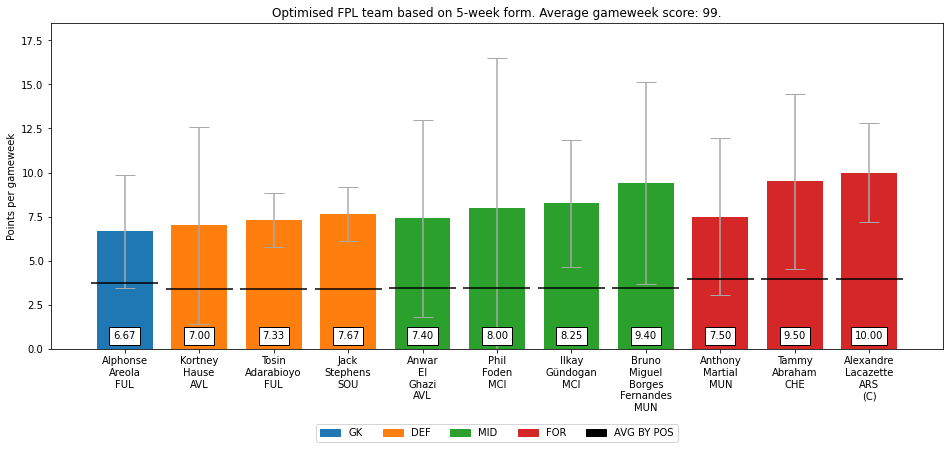

In [ ]:
# View performance of optimal team's players
# ------------------------------------------------------------------------------

# 
x_lines = np.linspace(0, 10, 11)
x_lines_start = x_lines - 0.45
x_lines_end = x_lines + 0.45
total_score = round((team_optimised['mean_points'] * team_optimised['multiplier']).sum())

# Plot results
plt.figure(figsize = (16, 6))
plt.bar(x = team_optimised['name_plot'], height = team_optimised['mean_points'], yerr = team_optimised['std_points'],
        width = 0.75, capsize = 10,
        color = team_optimised['element_colour'], ecolor = 'darkgrey')

# Format chart
plt.title('Optimised FPL team based on 5-week form. Average gameweek score: ' + str(total_score) + '.')
plt.ylabel('Points per gameweek')
plt.xticks(team_optimised['name_plot'], fontsize = 10, rotation = 0)
plt.ylim((0, team_optimised['mean_points'].max() + team_optimised['std_points'].max())) # Clip negative values
plt.hlines(y = team_optimised['mean_points_bl'], xmin = x_lines_start, xmax = x_lines_end)

# Create custom legend
colours = {'GK':'tab:blue', 'DEF':'tab:orange', 'MID':'tab:green', 'FOR':'tab:red', 'AVG BY POS':'black'}         
labels = list(colours.keys()) # Legend labels
handles = [plt.Rectangle(xy = (0,0), width = 1, height = 1,
                         color = colours[label]) for label in labels] # Rectangular legend markers
plt.legend(handles, labels, loc='lower center', bbox_to_anchor = (0.5, -0.3), ncol = 5) # Create legend and set location

# Pair each player and their points value, then loop through
for x,y in zip(team_optimised['name_plot'], team_optimised['mean_points']):

    label = '{:.2f}'.format(y) # Format points results to 2dp

    plt.annotate(label, # Data label (2dp)
                 (x, 0), # Position of label
                 textcoords = "offset points", # How label is positioned
                 xytext = (0, 10), # Distance from label to points (x,y)
                 ha = 'center', # Horizontal alignment
                 #va = 'bottom',
                 bbox = {'facecolor':'white'}
                 )
    
plt.show()

In [ ]:
# View fixtures of players from the optimal team
# ------------------------------------------------------------------------------

gw_current = cleaned['gameweek'].max()

fixtures_upcoming = fixtures[['id', 'event', 'kickoff_time', 'finished', 'team_h', 'team_a', 'team_h_difficulty', 'team_a_difficulty']]
fixtures_upcoming = fixtures_upcoming.dropna(axis = 0, subset = ['event'])
fixtures_upcoming.reset_index(drop = True, inplace = True)
fixtures_upcoming.rename(columns = {'event':'gameweek'}, inplace = True)
fixtures_upcoming = fixtures_upcoming.astype({'gameweek':int})
fixtures_upcoming['kickoff_time'] = pd.to_datetime(fixtures_upcoming['kickoff_time'])

fixtures_upcoming = fixtures_upcoming.loc[(fixtures_upcoming['gameweek'] > gw_current) & (fixtures_upcoming['finished'] == False)].sort_values(by = 'kickoff_time', ascending = True)

In [ ]:
# Extract the next 5 fixtures (and their difficulties) for each player from the optimal team
# ------------------------------------------------------------------------------

# Initialise arrays
fixtures_array = np.zeros((11, 5))
fixtures_array_short = np.zeros((11, 5), dtype = 'U3')
diff_array = np.zeros((11, 5))

# Loop through each player
for row, player in team_optimised.iterrows():
  
  player_team = player['team'] # Extract team
  
  # Create dataframe for player to find out information on their upcoming fixtures
  player_fixtures = fixtures_upcoming.loc[(fixtures_upcoming['team_h'] == player_team) | (fixtures_upcoming['team_a'] == player_team)] # Filter for given player's fixtures (home or away)
  player_fixtures = player_fixtures.nsmallest(n = 5, columns = 'kickoff_time') # Get next 5 upcoming games
  player_fixtures['opponent_team'] =  np.where(player_fixtures['team_h'] == player_team, player_fixtures['team_a'], player_fixtures['team_h']) # Determine the opponent team
  player_fixtures = player_fixtures.merge(teams_filt, how = 'left', left_on = 'opponent_team', right_on = 'id')

  # Extract fixtures information and write to array to be plotted in a heatmap
  player_fixtures_opp = player_fixtures['opponent_team'].to_numpy()
  player_fixtures_short = player_fixtures['short_name'].to_numpy()
  player_fixtures_opp_diff = player_fixtures['strength'].to_numpy()
  
  fixtures_array[row, :] = player_fixtures_opp # Insert information into initialised arrays
  fixtures_array_short[row, :] = player_fixtures_short
  diff_array[row, :] = player_fixtures_opp_diff

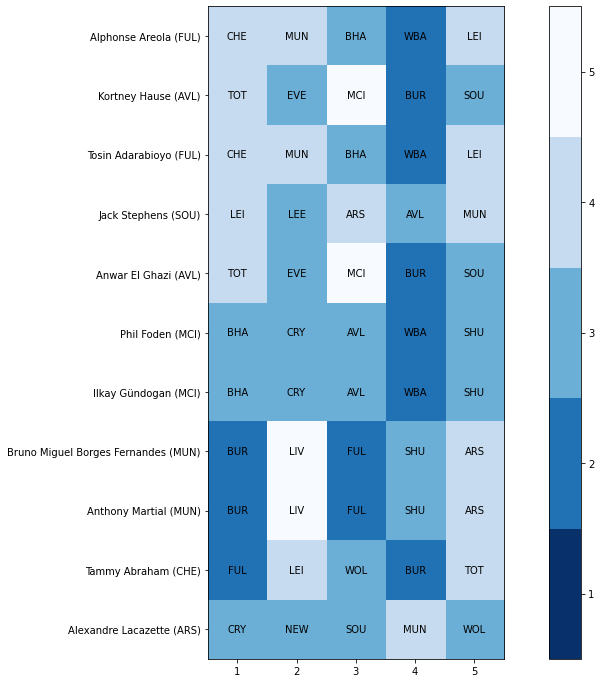

In [ ]:
# Produce heatmap to show upcoming fixtures and difficulties
# ------------------------------------------------------------------------------
numbers = [1, 2, 3, 4, 5]

colourmap = plt.get_cmap('Blues_r', 5) # Set up colourmap with 5 increments (fixture difficulty measured from 1-5)

# Create heatmap plot
fig, ax = plt.subplots(figsize = (16, 12))
im = ax.imshow(X = diff_array, cmap = colourmap, vmin = 0.5, vmax = 5.5) # Heatmap (fixture colours) determined by fixture difficulty from 1-5
cbar = plt.colorbar(im) # Create colourbar
cbar.set_ticks([1, 2, 3, 4, 5])
cbar.ax.set_yticklabels([1, 2, 3, 4, 5])

# Format heatmap
ax.set_xticks(np.arange(5)) # Insert xtick for each of the next 5 fixtures
ax.set_yticks(np.arange(11)) # Insert ytick for each of the team's 11 players
ax.set_xticklabels(numbers) # Label each game
ax.set_yticklabels(team_optimised['name'] + ' (' + team_optimised['team_short'] + ')') # Label each player

# Loop through each player in the team
for y in range(len(team_optimised['name'])):
    for x in range(len(numbers)): # Loop through each fixture
        text = ax.text(x, y, fixtures_array_short[y, x],
                       ha="center", va="center", color="black", size = 10)